<a href="https://colab.research.google.com/github/MCRLdata-Sandbox/tutorials/blob/main/ML_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Welcome!

This tutorial is designed to provide an introduction to machine learning (ML) for users with any level of experience with coding. All code is written in R, but you do NOT need to know or learn R to complete this tutorial!

ML is a subset of artificial intelligence (AI) where the computer can learn and improve its performance of a task without the user's input. It can be very useful for a wide variety of data-based tasks, and there are many different algorithms that perform many different types of tasks.

For this tutorial we will focus on one ML algorithm: Random Forests (RF). RF is a very useful algorithm we can use to predict relationships between different variables. RF is relativel robust to many of the factors that can cause problems in normal statistical models (things like co-correlation of predictors, non-normal distributions, and non-linear relationships).



## 2. Setup

Before we start anything, we need to set up our coding environment. Because getting a coding language like R or Python running on your computer is often an involved process, this tutorial takes advantage of Google Colab, which pre-loads all of the software you need. You do, however, need to install packages and set up your environment. We'll do this by running the code chunk below (press the play button in the upper-left).

**IMPORTANT: from here on, when you see a code chunk with a play button, you can press play! Please do not skip code chunks as the code below generally depends on the code above**

This code chunk will take a couple minutes (~3 minutes on my machine) because R needs to install and load several libraries. All other code chunks should be much faster!


In [1]:
## I want to understand how long things take
install.packages('tictoc')
library(tictoc)

## Install and load required packages
tic("install and load packages")
install.packages(c('tidyverse', 'rsample', 'fuzzyjoin', 'cowplot', 'ranger'))

library(tidyverse) # keeps our data flows tidy
library(rsample) # used for splitting data into train and test subsets
library(fuzzyjoin) # used to give leniency when joining data by timestamp
library(cowplot) # make multi-facet plots
library(ranger) # Random Forest algorithm
toc()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘warp’, ‘furrr’, ‘slider’, ‘RcppEigen’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




install and load packages: 118.344 sec elapsed


While that's loading, let's start with the question we want our model to answer - **Can we use basic hydrology and water quality data to predict aquatic carbon dioxide concentrations in Sequim Bay?**

This is a  common type of question to ask ML to solve and while it seems simple, finding the answer can be a complicated process. This tutorial leverages the awesome datasets being collected off the MCRL dock by the [MCRLdata](https://mcrldata.pnnl.gov/) pipeline. We will use the partial pressure of carbon dioxide in water (pCO2) as the variable we want to predict, and a range of parameters, including water temperature, tidal stage, windspeed, and others as our predictors.

Since this tutorial is focused on a practical application of ML and not on R coding, I will not explain code chunks in detail. If you are interested in a starting point for learning R, I suggest checking out these [tutorials](https://github.com/MCRLdata-Sandbox/tutorials), starting with [0_R_basics](https://github.com/MCRLdata-Sandbox/tutorials/blob/main/scripts/0_R_basics.R)

## 3. Import and check data

Now that we have all the packages loaded that we need, let's read in our datasets. These datasets live in the [MCRLdata Sandbox](https://github.com/MCRLdata-Sandbox)[<https://github.com/MCRLdata-Sandbox/data_prep/tree/main/data/outputs/L1>] and have basic quality control applied. We are going to use predictors from four datasets: 1. pCO2 - partial pressure of CO2 2. tide - tidal stage 3. ctd - water temperature 4. wind - windspeed:

In [6]:

## Read in data from https://github.com/MCRLdata-Sandbox/data_prep/tree/main/data/outputs/L1

pco2 <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250815_pco2_L1.csv")
tide <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250515_tidegauge_L1.csv")
ctd <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250815_ctd_water_temp_salinity_L1.csv")
wind <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250630_windspeed_L1.csv")

Rows: 4066 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (4): qc_pco2_water, qc_pco2_air, p_co2_in_water_ppm, p_co2_in_air_ppm
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 375940 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): tide, tide2
dbl  (1): water_level_m_navd88
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 249028 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): temp_deg_c, salinity_psu_clean
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set

### Check gaps

Random forests do not handle missing values well. If any value is missing for any dependent or independent variable included in the model, that row will not be included in the model. Let's do a gap analysis to understand what gaps we have in our dataset. We'll mark all gaps larger than 3 hours (the temporal resolution of our pCO2 dataset) with red dots:

Warning message:
“Removed 153736 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 107103 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 27 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 161632 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


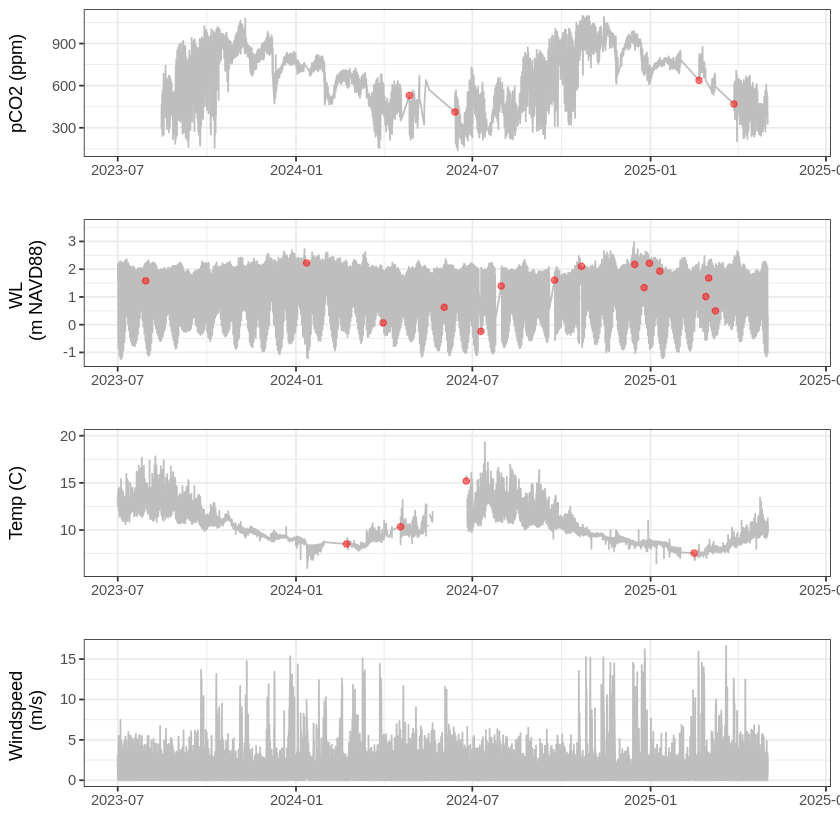

In [11]:
## For plots, let's set a theme
theme_set(theme_bw())

## Function to plot data gaps larger than 3 hours
plot_gaps <- function(data, var, ylab){

  gap_threshold = 60*60*3 #60s/min * 60min/hr * 3 hrs (pCO2 resolution)

  x <- data %>%
    mutate(delta_time = as.numeric(time_pst - lag(time_pst)))

  ggplot(x, aes(time_pst, {{var}})) +
    geom_line(color = "gray") +
    geom_point(data = x %>% filter(delta_time > gap_threshold), alpha = 0.5, color = "red") +
    labs(x = "", y = ylab) +
    scale_x_datetime(limits = c(as_datetime("2023-07-01"),
                              as_datetime("2025-06-01")))
}

## Make plots
plot_grid(plot_gaps(pco2, p_co2_in_water_ppm, "pCO2 (ppm)"),
          plot_gaps(tide, water_level_m_navd88, "WL \n (m NAVD88)"),
          plot_gaps(ctd, temp_deg_c, "Temp (C)"),
          plot_gaps(wind, windspeed_avg_m_s, "Windspeed \n (m/s)"),
          ncol = 1, align = "hv")

### Select dataset for model

Once we join our datasets together, keeping only rows with all the parameters we are wanting for our model, we can pick a convenient chunk of data that will work well to meet the Random Forest algorithm's preference for continuous data. A quick note here - gap-filling is a common approach for helping time-series meet the requirements of models like Random Forests that don't handle missing values well. **However**, it's important to remember that gapfilling, which follows some sort of algorithm, can add patterns into your dataset that the model can (wrongly) interpret as important. I suggest caution when using gap-filling for any model, including ML models, for this reason.

Looking at our time-matched dataset, there is a nice chunk of data that is not missing values towards the beginning of the time-series. We will use the data shaded in blue for our initial models.

In [ ]:
df_full <- inner_join(pco2 %>% dplyr::select(time_pst, p_co2_in_water_ppm),
                tide %>% dplyr::select(time_pst, water_level_m_navd88),
                by = "time_pst") %>%
  inner_join(., ctd %>% dplyr::select(time_pst, temp_deg_c),
                by = "time_pst") %>%
  inner_join(., wind %>% dplyr::select(time_pst, windspeed_avg_m_s),
                by = "time_pst") %>%
  unique()

plot_gaps2 <- function(data, var, ylab){

  gap_threshold = 60*60*3 #60s/min * 60min/hr * 3 hrs (pCO2 resolution)
  start1 = as_datetime("2023-08-15")
  end1 = as_datetime("2024-01-01")

  x <- data %>%
    mutate(delta_time = as.numeric(time_pst - lag(time_pst)))
  ggplot(x, aes(time_pst, {{var}})) +
    geom_line(color = "gray") +
    geom_point(data = x %>% filter(delta_time > gap_threshold), alpha = 0.5, color = "red") +
    annotate(geom = "rect", xmin = start1, xmax = end1,
             ymin = -Inf, ymax = Inf,
             fill = "blue", alpha = 0.1) +
    ylab(ylab) +
    scale_x_datetime(limits = c(as_datetime("2023-07-01"),
                                as_datetime("2025-06-01")))
}

plot_grid(plot_gaps2(df_full, p_co2_in_water_ppm, "pCO2 (ppm)") ,
          plot_gaps2(df_full, water_level_m_navd88, "WL \n (m NAVD88)"),
          plot_gaps2(df_full, temp_deg_c, "Temp (C)"),
          plot_gaps2(df_full, windspeed_avg_m_s, "Windspeed \n (m/s)"),
          ncol = 1, align = "hv")